In [15]:
using Pkg

using Flux
using MLDatasets
using Images
using Zygote
using Plots


In [2]:
train_X, train_y = MNIST(split=:train)[:]
test_X, test_y = MNIST(split=:test)[:]

# Normalize the images to the range [0, 1] and convert to Float32
train_X = Float32.(train_X ./ 255.0)
test_X = Float32.(test_X ./ 255.0)

# Reshape the data to match the expected input dimensions (length, channels, batch_size)
train_X = reshape(train_X, size(train_X, 1) * size(train_X, 2), 1, size(train_X, 3))
test_X = reshape(test_X, size(test_X, 1) * size(test_X, 2), 1, size(test_X, 3))

train_X = reshape(train_X, 28, 28, 1, size(train_X, 3))
test_X  = reshape(test_X, 28, 28, 1, size(test_X, 3))

;

In [39]:
model = Chain(
    Conv((3, 3), 1=>16, relu, pad=1),  # now expects input of shape (28,28,1,batch)
    MaxPool((2,2)),
    Conv((3,3), 16=>32, relu, pad=1),
    MaxPool((2,2)),
    Flux.flatten,
    Dense(7*7*32, 128, relu),
    Dense(128, 7*7*32, relu),
    x -> reshape(x, (7, 7, 32, size(x, 2))),
    ConvTranspose((3, 3), 32=>16, relu, stride=2, pad=1),
    ConvTranspose((3, 3), 16=>1, σ, stride=2, pad=1),
    x -> reshape(x, :, size(x, 4)),   # Flatten spatial dimensions, shape becomes (25*25*1, batch)
    Dense(25*25, 1),                  # Reduce each flattened sample to a single value
    x -> reshape(x, size(x, 2))        # Reshape so output is (batch,) matching y
)

;

In [40]:
loss(m, x, y) = mse(m(x), y)

opt = ADAM();

In [41]:
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    opt_state = Flux.setup(opt, model)  
    total_loss = []

    for epoch in 1:epochs
        epoch_loss = 0
        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
            Flux.update!(opt_state, Flux.trainable(model), gs)
            epoch_loss += Flux.Losses.mse(model(x), y)
        end
        println("Epoch $epoch complete")
        push!(total_loss, epoch_loss)
    end
    return total_loss
end;

In [42]:
epochs = 3
batch_size = 64
;

In [43]:
loss_list = train_model!(model, train_X, train_y, opt, epochs, batch_size);

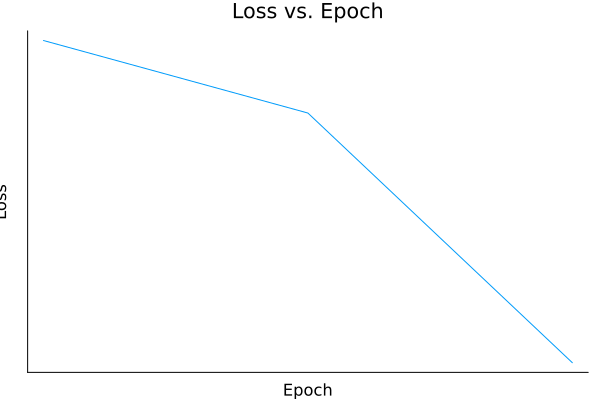

In [ ]:
p1 = plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [ ]:
random_input = rand(Float32, 28, 28, 1, 1)

;

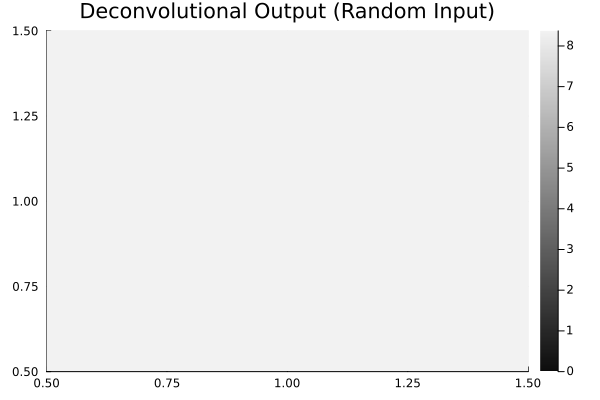

In [ ]:
output = model(random_input)

# Remove the extra batch dimension (dimension 4) for visualization
output_image = output[:, :, 1, 1]  # Indexing to remove the batch and channel dimensions

# Plot the output as an image
heatmap(output_image, color=:grays, title="Deconvolutional Output (Random Input)")